In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import pandas as pd
import os
import seaborn as sns
import keras

## Problem Description and Data

The goal of this project is to build a Convolutional Neural Network that would classify metastatic cancer in small image patches. The dataset used is provided by Kaggle: Histopathologic Cancer Detection: <https://www.kaggle.com/c/histopathologic-cancer-detection/data>

The data downloaded here is split into train and test sets, and it is the test set that will determine the final Kaggle score. The dataset consists of 96 by 96 pixel images with 3 color channels for a total of 27,648 total inputs per image. However, only the center 32 by 32 pixel patch of each image actually determines the classification (according to Kaggle). Each image comes in a .tif format and is named {id}.tif. For the training set, a csv is also provided where the images id is recorded as either 1 (positive for metastatic cancer) or 0 (negative for metastatic cancer). Below is an example of one of these image files. This particular image is negative for metastatic cancer.

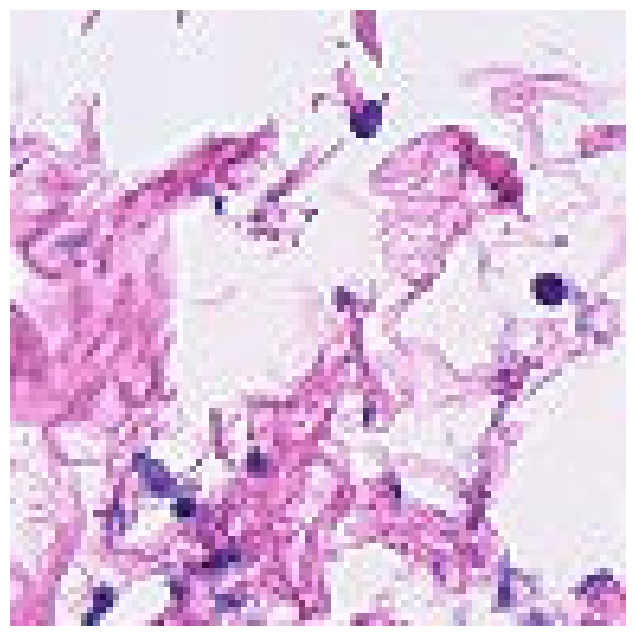

In [2]:
image = Image.open('./data/train/0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif')
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

## EDA 

### Initial Conseriderations: Dataset Preview, Missing Data, Dataset Skew

#### 1. Dataset Preview
Important to take a look at a few samples of both positive and negative labels



In [3]:
#Load training dataset labels:
data_labels = pd.read_csv('./data/train_labels.csv')
data_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


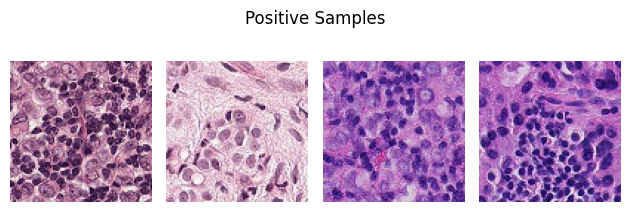

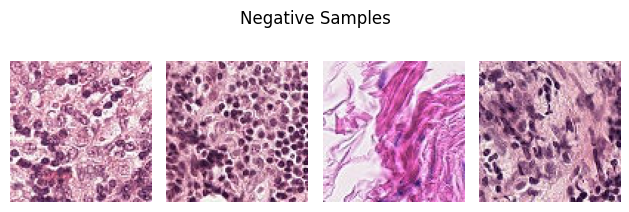

In [4]:
# Printing off some samples of both positive and negative cases
num_samples = 4

positive_samples = data_labels.loc[data_labels['label'] == 1].sample(num_samples)
negative_samples = data_labels.loc[data_labels['label'] == 0].sample(num_samples)

fig, axes = plt.subplots(1, num_samples)
for idx, a in enumerate(axes):
    image = Image.open('./data/train/' + positive_samples.iloc[idx]['id'] + '.tif')
    a.imshow(image)
    a.axis('off')
fig.suptitle("Positive Samples", y=.72)
plt.tight_layout()

fig, axes = plt.subplots(1, num_samples)
for idx, a in enumerate(axes):
    image = Image.open('./data/train/' + negative_samples.iloc[idx]['id'] + '.tif')
    a.imshow(image)
    a.axis('off')
fig.suptitle("Negative Samples", y=.72)
plt.tight_layout()



#### 2. Missing Data
Quick Check on the Images and CSV to ensure that all images have associated labels. 


In [5]:
# Missing Data Check

# First to see if there are any non-labeled ids:
print("Check to see if data labels have any missing data\n", data_labels.isna().sum())
# No missing labels at least in the csv

# Check to see if all labels in the csv have a matching .tif
# Extract all expected file paths from the labels DataFrame
label_ids = data_labels['id'].tolist()
missing_files = []
# Check for each label if the corresponding .tif file exists
for label_id in label_ids:
    image_path = os.path.join('./data/train', f"{label_id}.tif")
    if not os.path.exists(image_path):
        missing_files.append(label_id)

print('Number of missing tif files:', len(missing_files))

Check to see if data labels have any missing data
 id       0
label    0
dtype: int64
Number of missing tif files: 0


#### 3. Dataset Skew
Our training dataset may have a large amount of either positive or negative classifying cases. This skew may need to be addressed to get better model performance.


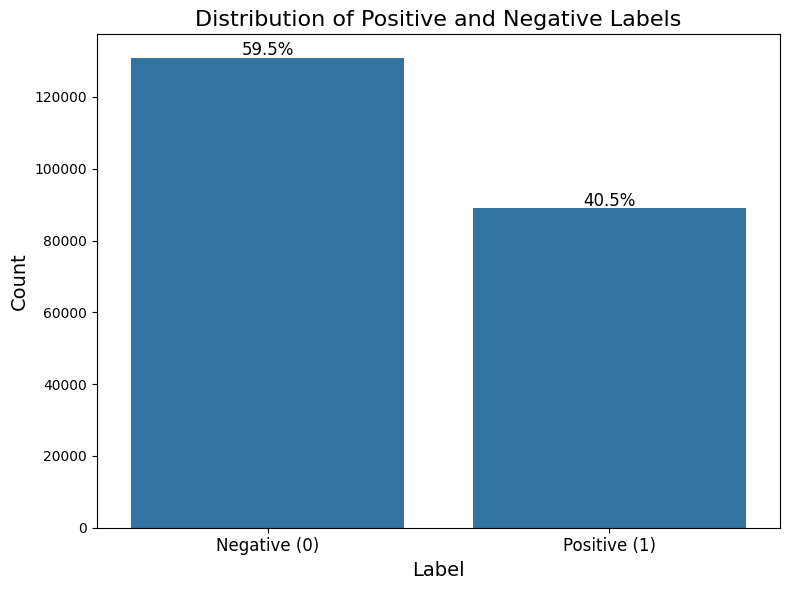

In [6]:
# Extract label counts and percentages
label_counts = data_labels['label'].value_counts()
total_samples = len(data_labels)
percentages = (label_counts / total_samples) * 100


plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)

# Annotate percentages on the bars
for i, (count, percentage) in enumerate(zip(label_counts.values, percentages)):
    plt.text(i, count*1.005, f"{percentage:.1f}%", ha='center', fontsize=12)

plt.title("Distribution of Positive and Negative Labels", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(ticks=[0, 1], labels=["Negative (0)", "Positive (1)"], fontsize=12)
plt.tight_layout()

plt.show()


## Description of Model
The data provided seems to be of good quality. There is no missing labels, and the dataset skew isn't too bad. Just by looking at the positive and negative samples, I am unable to tell which categories the images belong to. I'll start the investigation process by building a simple CNN model, of type (CNN CNN Maxpool) * n --> Dense Classifier. I'll set n arbitrarily to 3 at the start, and will allow this to be tweaked as I refine the model. 


To start, I will use CNNs layers with 100 filters, then down to 50, and the final CNN layer will have 25. Since early CNN layers pick up the most basic features of a dataset, having plenty of these will hopefully allow the later stages to combine these basic features into more complex ones that will have a better indication on the outcome. 


Afterwards the classifier will be two dense layers of 128 and then 64 nodes, and one output node.

All hidden layers will make use of the ReLu activation function, and the output layer will be a sigmoid activation since this is a classifier type problem.




In [12]:
basic_model = keras.Sequential([
    keras.Input(shape=(96, 96, 3)),
    
    
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')      


])


basic_model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 92, 92, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 44, 44, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 42, 42, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 19, 19, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 17, 17, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,897 (831.63 KB)

 Trainable params: 212,897 (831.63 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
basic_model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy'] 
)


ids = data_labels['id'].values
labels = data_labels['label'].values



dataset = tf.data.Dataset.from_tensor_slices((ids, labels))


def load_and_preprocess_images(id, label):
    image = Image.open('./data/train/' + positive_samples.iloc[idx]['id'] + '.tif')
    image = image.convert('RGB')
    
    # Convert the image to a numpy array
    image = np.array(image)

    # Convert the image to a TensorFlow tensor and normalize it to the range [0, 1]
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0
    return image, label


dataset = dataset.map(load_and_preprocess_images)


# Dataset Proccessing

dataset = dataset.shuffle(buffer_size=10000)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

train_size = int(0.8 * len(labels))
val_size = len(labels) - train_size




train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

train_dataset = train_dataset.batch(batch_size=32)





In [15]:
basic_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)


Epoch 1/10
3527/5501 ━━━━━━━━━━━━━━━━━━━━ 4:35 140ms/step - accuracy: 0.5986 - loss: 0.6762

KeyboardInterrupt: 